In [1]:
import torch
from utils import prepare_data
from train import get_dataloaders
import pandas as pd
import numpy as np
from params import PARAMS
from sklearn.model_selection import train_test_split
# from models import GCNAuto, GCRAM
from main import init_model_params

from train import train_model_2
from main import model_predict, print_classification_report
from torch import nn
import torch.nn.functional as F
from layers import BatchGraphConvolutionLayer
import math

RANDOM_SEED = 0
SEQ_LEN = 64
N_EPOCHS = 100
BATCH_SIZE = 64

# Load dataset

In [2]:
from utils import load_data

X_train, y_train, X_test, y_test = load_data('dataset/train/cross_subject_data_0_5_subjects.pickle')

X_train = np.vstack([X_train, X_test])
y_train = np.hstack([y_train, y_test])
N_CLASSES = len(np.unique(y_train))

print('Original shapes:')
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('Labels:', np.unique(y_train))
print('Num classes:', N_CLASSES)

Original shapes:
X_train shape: (352652, 64)
y_train shape: (352652,)
Labels: [0 1 2 3]
Num classes: 4


In [3]:
# X_train_0 = X_train[y_train == 0]
# X_train_1 = X_train[y_train == 1]

# X_train = np.vstack([X_train_0, X_train_1])

# y_train_0 = y_train[y_train == 0]
# y_train_1 = y_train[y_train == 1]

# y_train = np.hstack([y_train_0, y_train_1])
# N_CLASSES = len(np.unique(y_train))

# print('Left hand, right hand data:')
# print('X_train shape:', X_train.shape)
# print('y_train shape:', y_train.shape)
# print('Labels:', np.unique(y_train))
# print('Num classes:', N_CLASSES)


In [4]:
X_train, y_train = prepare_data(X_train, y_train, SEQ_LEN)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=PARAMS['TEST_SIZE'], shuffle=True, random_state=RANDOM_SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=PARAMS['VALID_SIZE'], shuffle=False, random_state=RANDOM_SEED)
print('Split shapes:')
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_valid shape:', X_valid.shape)
print('y_valid shape:', y_valid.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

dataloaders = get_dataloaders(X_train, y_train, X_valid, y_valid, X_test, y_test, PARAMS['BATCH_SIZE'], random_seed=RANDOM_SEED, device=PARAMS['DEVICE'])

Split shapes:
X_train shape: (4463, 64, 64)
y_train shape: (4463,)
X_valid shape: (496, 64, 64)
y_valid shape: (496,)
X_test shape: (551, 64, 64)
y_test shape: (551,)


In [5]:
class GCNAuto(nn.Module):
    def __init__(self, kernel_type, in_features, n_nodes, num_classes, hidden_sizes, dropout_p, device):
        super(GCNAuto, self).__init__()

        self.kernel_type = kernel_type
        self.dropout_p = dropout_p
        

        self.gc1 = BatchGraphConvolutionLayer(in_features, hidden_sizes[0], n_nodes)
        self.gc2 = BatchGraphConvolutionLayer(hidden_sizes[0], hidden_sizes[1], n_nodes)
        self.gc3 = BatchGraphConvolutionLayer(hidden_sizes[1], hidden_sizes[2], n_nodes)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(hidden_sizes[2]*n_nodes, num_classes)

        self.eye = torch.eye(n_nodes, device=device)
        self.adj = nn.Parameter(torch.randn(n_nodes, n_nodes))

    def forward(self, x):
        if self.kernel_type == 'a':
            adj = self.kernel_a()
        if self.kernel_type == 'b':
            adj = self.kernel_b()
        if self.kernel_type == 'c':
            adj = self.kernel_c()
        if self.kernel_type == 'd':
            adj = self.kernel_d()

        out = F.relu(self.gc1(x, adj))
        out = F.dropout(out, p=self.dropout_p)

        out = F.relu(self.gc2(out, adj))
        out = F.dropout(out, p=self.dropout_p)

        out = F.relu(self.gc3(out, adj))
        out = F.dropout(out, p=self.dropout_p)

        out = self.flatten(out)
        out = self.linear(out)

        return out

    def kernel_a(self):
        return self.adj

    def kernel_b(self):
        return torch.mm(self.adj, self.adj.T)

    def kernel_c(self):
        return torch.mm(self.adj, self.adj.T) + self.eye

    def kernel_d(self):
        return F.softmax(torch.mm(self.adj, self.adj.T) + self.eye) 
    
    def init_node_embeddings(self):
        stdv = 1. / math.sqrt(self.adj.size(1))
        self.adj.data.uniform_(-stdv, stdv)
        self.adj.data.fill_diagonal_(1)

In [6]:
for kernel_type in ['a']:
    print('#'*20)
    print('Kernel Type:', kernel_type)
    print('#'*20)
    model = GCNAuto(kernel_type=kernel_type, in_features=SEQ_LEN, n_nodes=PARAMS['N_CHANNELS'], num_classes=N_CLASSES, hidden_sizes=PARAMS['GCNAUTO_HIDDEN_SIZES'], dropout_p=0.4, device=PARAMS['DEVICE'])

    model = init_model_params(model, random_seed=RANDOM_SEED)
    if kernel_type in 'ab':
        model.init_node_embeddings()

    model = model.to(PARAMS['DEVICE'])

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    # best_model, history = train_model(dataloaders, dataset_sizes, model, criterion, optimizer, scheduler, PARAMS['N_EPOCHS'], random_seed=random_seed)
    best_model, history = train_model_2(model, optimizer, scheduler, criterion, dataloaders['train'], dataloaders['val'], N_EPOCHS, RANDOM_SEED, PARAMS['DEVICE'])
    best_model = best_model.to(PARAMS['DEVICE'])

    y_preds, y_test = model_predict(best_model, test_loader=dataloaders['test'])

    cr, cm, auroc = print_classification_report(y_test, y_preds, N_CLASSES, PARAMS['LABEL_MAP'])

    y_preds, y_test = model_predict(model, test_loader=dataloaders['test'])


    cr, cm, auroc = print_classification_report(y_test, y_preds, N_CLASSES, PARAMS['LABEL_MAP'])

    print(cr)
    print('Confusion matrix:')
    print(cm)
    print('AUROC:', auroc)
    print('#'*40)

####################
Kernel Type: a
####################
train() called: model=GCNAuto, opt=Adam(lr=0.001000), epochs=100, device=cuda

Epoch   1/100, LR 0.0010, train loss: 2.3132, train acc: 0.2541, val loss: 1.2630, val acc: 0.2634
Epoch  10/100, LR 0.0010, train loss: 1.2130, train acc: 0.4067, val loss: 1.1582, val acc: 0.3839
Epoch  20/100, LR 0.0009, train loss: 0.9997, train acc: 0.5217, val loss: 1.1068, val acc: 0.4487
Epoch  30/100, LR 0.0008, train loss: 0.8467, train acc: 0.6044, val loss: 1.2722, val acc: 0.4598
Epoch  40/100, LR 0.0007, train loss: 0.7506, train acc: 0.6621, val loss: 1.2637, val acc: 0.4955
Epoch  50/100, LR 0.0007, train loss: 0.6537, train acc: 0.7181, val loss: 1.3802, val acc: 0.5201
Epoch  60/100, LR 0.0006, train loss: 0.5646, train acc: 0.7597, val loss: 1.7833, val acc: 0.4531
Epoch  70/100, LR 0.0005, train loss: 0.4819, train acc: 0.8107, val loss: 1.9043, val acc: 0.5045
Epoch  80/100, LR 0.0005, train loss: 0.4082, train acc: 0.8342, val los

In [7]:
adj = model.adj.cpu().detach().numpy()

<AxesSubplot:>

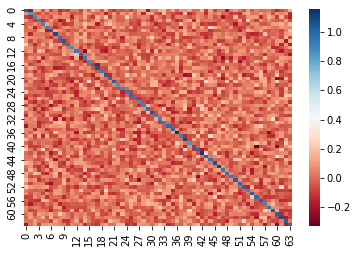

In [8]:
import seaborn as sns

sns.heatmap(adj, cmap='RdBu')

<AxesSubplot:>

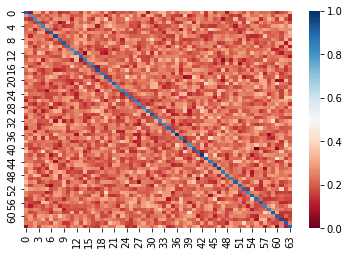

In [9]:
adj_scaled = (adj - adj.min()) / (adj.max() - adj.min())

sns.heatmap(adj_scaled, cmap='RdBu')

In [10]:
import pandas as pd
channel_names = pd.read_csv('dataset/physionet.org_csv_full_imagine/S001_imagine.csv')
channel_names = channel_names.columns[3:].values
idc = [i for i in range(len(channel_names))]
channel_map = {idc[i]: channel_names[i] for i in range(len(channel_names))}

In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from graph_utils import get_sensor_pos

def adj2edgelist(adj):
    edge_list = []
    for u in range(len(adj)):
        for v in range(len(adj)):
            if adj[u, v] == 0:
                continue
            elif adj[u, v] < 0:
                edge_list.append([u, v, 'r', adj[u, v]])
            else:
                edge_list.append([u, v, 'b', adj[u, v]])
    return edge_list

def plot_adj_as_graph(adj_mat, threshold, channel_names):
    np.fill_diagonal(adj_mat, 0)
    adj_mat = np.where(abs(adj_mat) > threshold, adj_mat, 0)
    adj_mat = np.round(adj_mat, 2)

    edge_list = adj2edgelist(adj_mat)

    G = nx.DiGraph()
    for (u, v, color, weight) in edge_list:
        G.add_edge(u, v, color=color, weight=weight)
    G.add_nodes_from(channel_names)

    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight']*20 for u,v in edges]
    plt.figure(figsize=(10, 7))
    
    G = nx.relabel_nodes(G, {idc[i]: channel_names[i] for i in range(len(channel_names))})

    ch_pos_1010 = get_sensor_pos(channel_names)
    coor = np.array(list(ch_pos_1010.values()))

    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    coor = pca.fit_transform(coor)
    pos = {}
    for idx, (k, v) in enumerate(ch_pos_1010.items()):
        pos[k] = coor[idx].tolist()

    # nx.draw_networkx_nodes(G, pos=pos, alpha=0.1)
    nx.draw(G, pos=pos, with_labels=True, node_size=600, edge_color=colors, width=weights)
    edge_labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(f'Threshold (%): {int(threshold*100)}')
    plt.show()

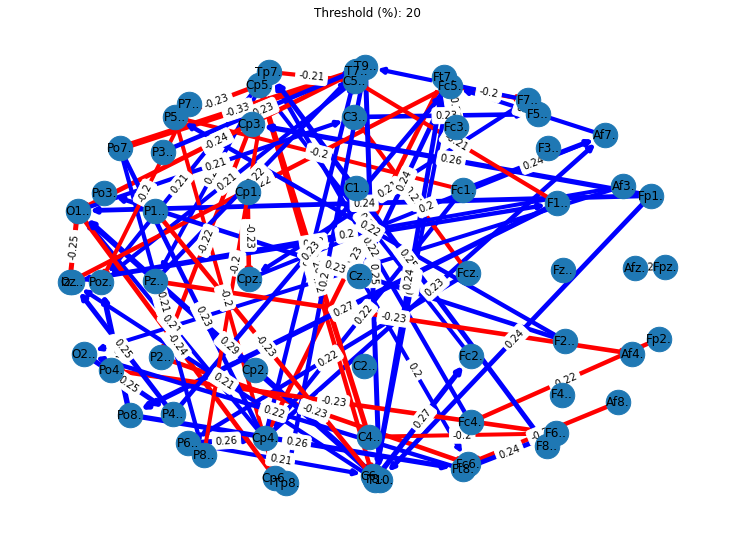

In [12]:
plot_adj_as_graph(adj, 0.2, channel_names)